# Notebook 05: Regression - Predicting Sales for New Models

This notebook develops a regression model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer

# custom function imports
from custom_functions import *
from regression_custom_functions import *

In [9]:
# Import data
df_all_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

time_now = datetime.datetime.now()
df_models = df_all_models.dropna(subset=time_now.strftime(f"%Y-%m"))

In [10]:
#df_models = df_models.merge(pd.DataFrame(return_date_col(df_models.set_index('style_id')).T.sum(),columns=['overall_sales']),left_on = 'style_id',right_index=True)

### Train-test split

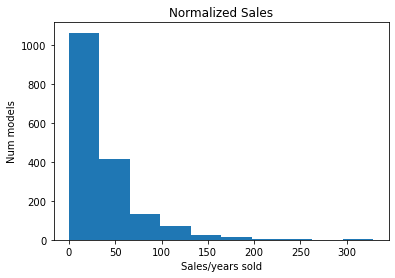

In [11]:
# Calculate a target value - Normalized Sales, which is the overall sales divided by the number of years that the model was sold
df_models = calc_norm_sales(df_models)

In [12]:
attributes = ['max_cart_qty','country_of_origin','warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'gender', 'color',
       'retail_price', 'collection', 'clasp_type', 'water_resistance',
       'movement_type']

X = df_models[attributes]

# Check no null values in X
df_models[df_models.isna()].sum().sum() #Should return 0

0.0

In [13]:
df_models

,style_id,max_cart_qty,availability,qty_on_hand,qty_on_order,qty_total_inv,qty_sold_last_6m,qty_avg/mo,months_of_supply,xyz_cost,...,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,overall_sales,norm_sales
0,am4141,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,736.0,147.200000
1,am4183,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,136.250000
2,am4481,no max quantity reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,489.0,122.250000
3,am4482,no max quantity reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,303.0,101.000000
4,am4483,no max quantity reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302.0,100.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,me3214,100,available,17.0,0.0,17.0,3.0,0.5,34.0,73.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.000000
1720,me3217,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1721,me3218,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1722,me3219,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [14]:
y = df_models['norm_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model

In [15]:
baseline = np.full_like(y_test, y_train.mean())

In [16]:
rmse_baseline = mean_squared_error(y_test,baseline,squared=False)
rmse_baseline

30.549539363532595

In [17]:
residuals_baseline = y_test - baseline

In [18]:
r2_baseline = r2_score(y_test,baseline)
r2_baseline

-0.005632179565686846

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


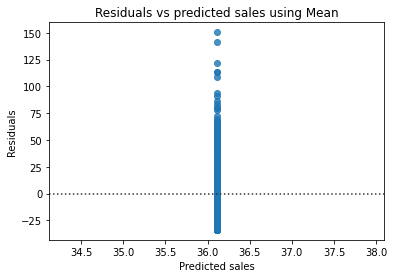

In [19]:
sns.residplot(x = baseline,
              y = residuals_baseline,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales using Mean')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

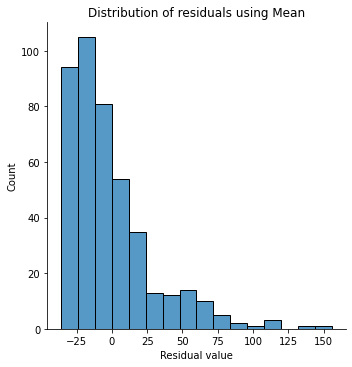

In [20]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_baseline, binwidth =12)
plt.title('Distribution of residuals using Mean')
plt.xlabel('Residual value');

Definitely not normally distributed. There is a tail for the higher sales models.

## Exploring different models

In [21]:
models = [('lr',LinearRegression()), ('ridge',RidgeCV(alphas=np.logspace(0,5,100))),
          ('lasso',LassoCV(alphas=np.arange(0.001,10,1))),('knn',KNeighborsRegressor(n_neighbors=3)),
          ('rf', RandomForestRegressor(n_estimators=500)), ('ab', AdaBoostRegressor(base_estimator=RandomForestRegressor())),
          ('et', ExtraTreesRegressor(n_estimators=200))]

In [22]:
y_test

300     26.000000
1075    32.812500
535     40.000000
1318     0.000000
561     33.333333
          ...    
1713    24.000000
818     45.000000
1110     0.000000
1420     0.000000
530     45.500000
Name: norm_sales, Length: 431, dtype: float64

In [23]:
best_rmse = 1000000
df_preds = pd.DataFrame(y_test.values, columns=['y_test'])

LinearRegression()
Train score: 0.5980391522233748
Test raw score: -8.253939999459547e+24
Test cleaned score: 0.2585035215781556
Test cleaned RMSE: 26.232496981307815
Baseline RMSE: 30.549539363532595


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Train score: 0.5615128015770519
Test raw score: 0.331335444996372
Test cleaned score: 0.3367824531708221
Test cleaned RMSE: 24.80921878924801
Baseline RMSE: 30.549539363532595

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]))


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91158.13114475139, tolerance: 153.2576636086671
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

Train score: 0.4568590859537549
Test raw score: 0.30034251999361217
Test cleaned score: 0.3016022399493692
Test cleaned RMSE: 25.458716449267833
Baseline RMSE: 30.549539363532595

KNeighborsRegressor(n_neighbors=3)
Train score: 0.5913095508880706
Test raw score: -0.08191223610371456
Test cleaned score: -0.08191223610371456
Test cleaned RMSE: 31.686998365529444
Baseline RMSE: 30.549539363532595

RandomForestRegressor(n_estimators=500)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train score: 0.893921593047472
Test raw score: 0.34593148613888536
Test cleaned score: 0.34593148613888536
Test cleaned RMSE: 24.63750394094824
Baseline RMSE: 30.549539363532595


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



AdaBoostRegressor(base_estimator=RandomForestRegressor())
Train score: 0.7620136468866303


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test raw score: 0.21895926690894862


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test cleaned score: 0.21895926690894862
Test cleaned RMSE: 26.92290551958444
Baseline RMSE: 30.549539363532595

ExtraTreesRegressor(n_estimators=200)
Train score: 0.9573435644984971
Test raw score: -0.018438410639932457
Test cleaned score: 0.008194859033330948
Test cleaned RMSE: 30.33879047933265
Baseline RMSE: 30.549539363532595


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Best RMSE: 24.63750394094824
Best model: rf


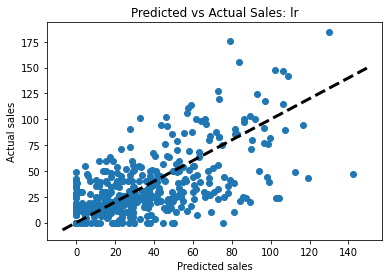

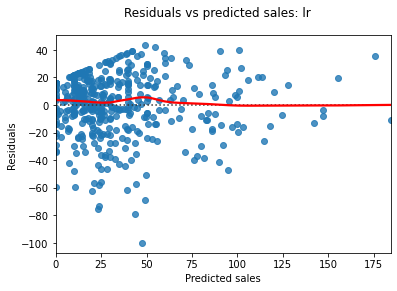

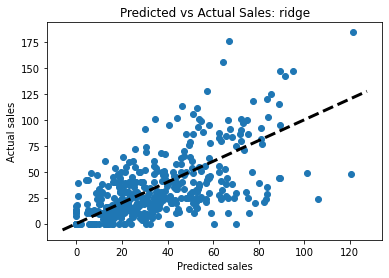

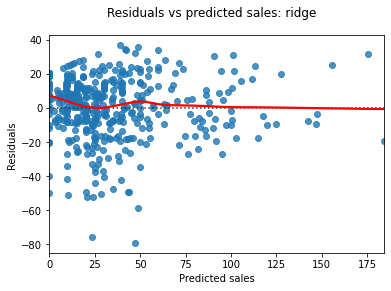

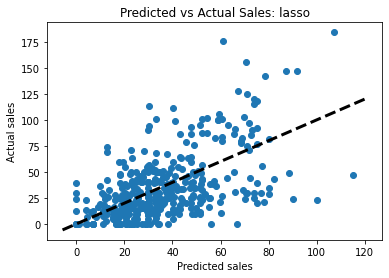

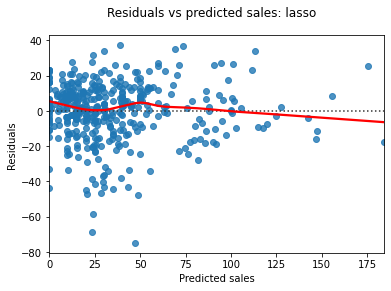

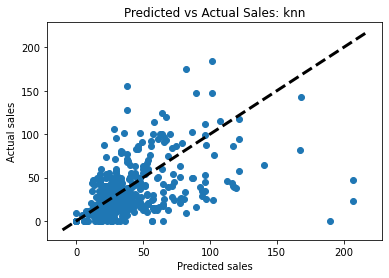

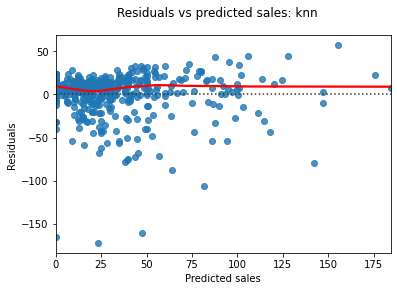

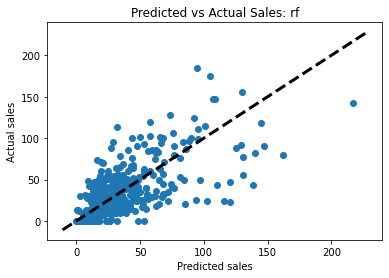

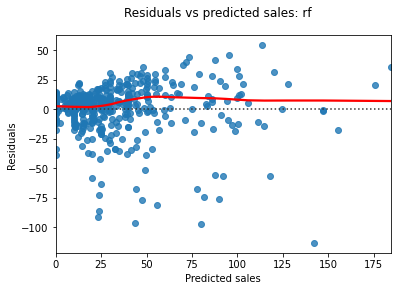

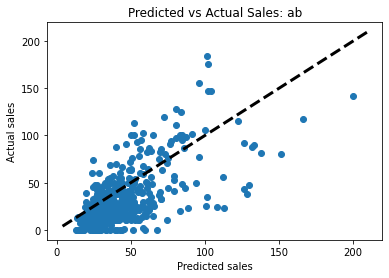

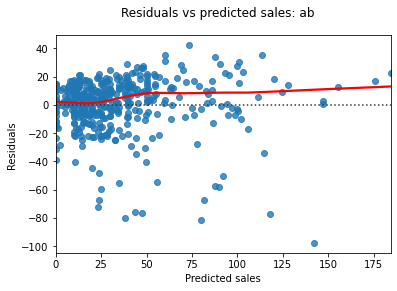

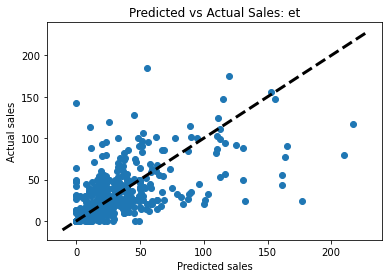

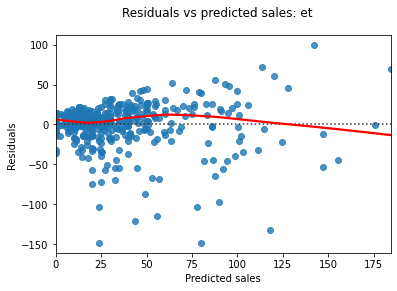

In [24]:
for model in models:
    preds, rmse = create_evaluate_model(model, X_train, X_test, y_train, y_test)
    df_preds[f'preds_{model[0]}'] = preds
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model[0]
        
print('Best RMSE:', best_rmse)
print('Best model:', best_model)

In [25]:
df_preds_avg = df_preds[['preds_ridge','preds_rf']]
df_preds['avg'] = 0
for pred in df_preds_avg:
    df_preds['avg'] = df_preds['avg'] + df_preds_avg[pred]
df_preds['avg'] = df_preds['avg']/len(df_preds_avg.columns)

In [26]:
df_preds

,y_test,preds_lr,preds_ridge,preds_lasso,preds_knn,preds_rf,preds_ab,preds_et,avg
0,26.000000,24.989313,31.109076,30.351277,26.833333,31.369974,36.592541,30.000000,31.239525
1,32.812500,61.598688,52.371927,52.078234,64.500000,68.580935,70.523667,88.312500,60.476431
2,40.000000,26.645563,33.878622,35.239699,22.233333,27.405090,34.739119,19.285714,30.641856
3,0.000000,12.223688,15.503049,17.796514,6.571429,9.117081,24.797926,11.019643,12.310065
4,33.333333,42.614313,44.066929,39.402991,40.022222,45.937846,44.711500,50.400000,45.002387
...,...,...,...,...,...,...,...,...,...
426,24.000000,0.000000,9.079920,0.000000,29.283333,16.732929,18.920952,24.180000,12.906424
427,45.000000,5.879938,16.189593,27.716913,47.500000,12.855200,24.630575,7.825000,14.522396
428,0.000000,10.270563,21.150626,34.239797,32.333333,23.902714,33.568333,28.414167,22.526670
429,0.000000,0.000000,9.889434,20.807061,19.250000,13.852396,17.880833,0.000000,11.870915


In [27]:
mean_squared_error(y_test,df_preds['avg'],squared=False)

22.84472502064357

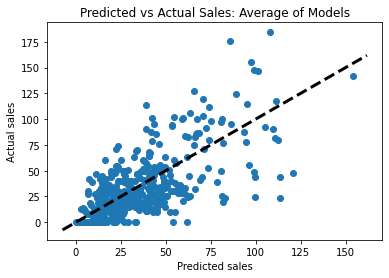

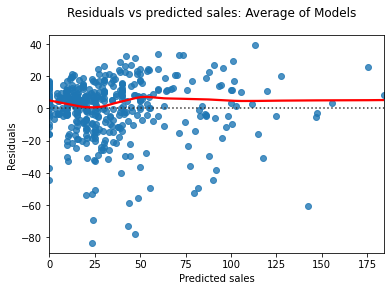

In [28]:
plot_preds(df_preds['y_test'],df_preds['avg'],'Average of Models')

## Production model

In [29]:
# Create new data frame with attributes from model to make predictions for new models in proposal
df_new_models = df_all_models[df_all_models[time_now.strftime(f"%Y-%m")].isna()]
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

# Create a column transformer to one hot encode categorical variables
categorical_attributes = []
for attribute in X_train.columns:
    try:
        int(attribute)
    except:
        categorical_attributes.append(attribute)

# Setup pipeline for preprocessing and modeling
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         categorical_attributes)],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('rf',RandomForestRegressor(n_estimators=500))
])

# Fit model with train set
pipe.fit(X_train,y_train)

# Generate predictions for new models
preds = pipe.predict(test)

# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions['monthly_predictions_Q3'] = preds/12

new_model_predictions.to_csv('../data/predictions/new_models_predictions.csv',index=False)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_43903/2853454165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 7, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_43903/2853454165.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<AxesSubplot:>

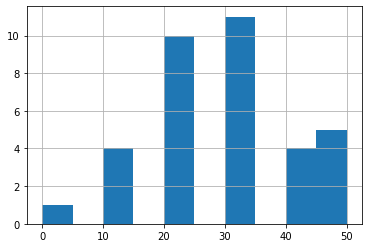

In [30]:
df_new_models.planned_order.hist()

(array([7., 4., 5., 6., 4., 2., 1., 1., 3., 2.]),
 array([ 0.174     ,  3.6299669 ,  7.08593381, 10.54190071, 13.99786762,
        17.45383452, 20.90980143, 24.36576833, 27.82173524, 31.27770214,
        34.73366905]),
 <BarContainer object of 10 artists>)

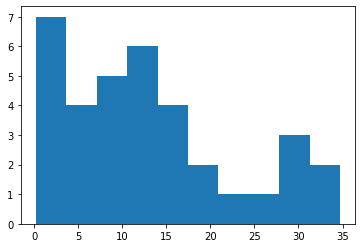

In [34]:
plt.hist(preds)

<AxesSubplot:>

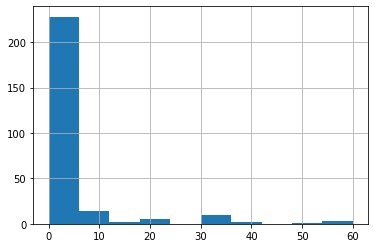

In [31]:
df_models.planned_order.hist()